# Backpropagation: Mathematical Derivation and Implementation

This notebook provides a comprehensive walkthrough of backpropagation, including:
1. **Mathematical foundations** - Chain rule and vector calculus
2. **Step-by-step derivations** - From scalar to matrix form
3. **Numerical examples** - Manual calculations with verification
4. **Visualization** - Gradient flow and computational graphs
5. **Implementation details** - From theory to code

## 🎯 Learning Objectives

By the end of this notebook, you will understand:
- How the chain rule applies to neural networks
- Mathematical derivation of backpropagation for any architecture
- Relationship between forward and backward passes
- Common implementation pitfalls and numerical considerations
- Gradient checking and debugging techniques


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy import symbols, diff, exp, log, tanh, simplify
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Libraries imported successfully!")
print("SymPy version:", sp.__version__)
print("NumPy version:", np.__version__)


Libraries imported successfully!
SymPy version: 1.13.3
NumPy version: 1.24.4


## 📚 Part 1: Mathematical Foundations

### 1.1 Chain Rule for Scalar Functions

The chain rule is the foundation of backpropagation. For a composite function $f(g(x))$:

$$\frac{df}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

**Example**: $f(x) = \sin(x^2)$
- Let $u = x^2$, so $f = \sin(u)$
- $\frac{df}{dx} = \frac{df}{du} \cdot \frac{du}{dx} = \cos(u) \cdot 2x = 2x\cos(x^2)$

### 1.2 Chain Rule for Vector Functions

For vector-valued functions, we use Jacobians:

$$\frac{\partial \mathbf{f}}{\partial \mathbf{x}} = \frac{\partial \mathbf{f}}{\partial \mathbf{u}} \frac{\partial \mathbf{u}}{\partial \mathbf{x}}$$

Where $\frac{\partial \mathbf{f}}{\partial \mathbf{u}}$ is the Jacobian matrix:

$$J = \begin{bmatrix}
\frac{\partial f_1}{\partial u_1} & \frac{\partial f_1}{\partial u_2} & \cdots \\
\frac{\partial f_2}{\partial u_1} & \frac{\partial f_2}{\partial u_2} & \cdots \\
\vdots & \vdots & \ddots
\end{bmatrix}$$


In [2]:
# Demonstrate chain rule with SymPy
print("Chain Rule Demonstration with SymPy")
print("=" * 40)

# Define symbolic variables
x, u = symbols('x u')

# Example 1: Simple composition f(u(x))
print("\n1. Simple Composition: f(x) = sin(x²)")
u_func = x**2
f_func = sp.sin(u_func)

# Manual chain rule
df_du = sp.cos(u)  # derivative of sin(u)
du_dx = diff(u_func, x)  # derivative of x²
manual_derivative = df_du.subs(u, u_func) * du_dx

# Automatic differentiation
auto_derivative = diff(f_func, x)

print(f"Manual chain rule: {manual_derivative}")
print(f"Auto differentiation: {auto_derivative}")
print(f"Simplified: {simplify(auto_derivative)}")
print(f"Match: {simplify(manual_derivative - auto_derivative) == 0}")

# Example 2: Neural network-like function
print("\n2. Neural Network Function: f(x) = σ(w·x + b)")
w, b = symbols('w b')
z = w*x + b  # linear transformation
sigmoid = 1 / (1 + exp(-z))  # sigmoid activation

# Compute derivative
dsigmoid_dx = diff(sigmoid, x)
print(f"σ'(w·x + b) = {simplify(dsigmoid_dx)}")

# Express in terms of σ(z)
sigma_z = symbols('sigma_z')
# σ'(z) = σ(z)(1 - σ(z))
sigma_derivative = sigma_z * (1 - sigma_z)
print(f"In terms of σ(z): σ'(z) = σ(z)(1 - σ(z))")


Chain Rule Demonstration with SymPy

1. Simple Composition: f(x) = sin(x²)
Manual chain rule: 2*x*cos(x**2)
Auto differentiation: 2*x*cos(x**2)
Simplified: 2*x*cos(x**2)
Match: True

2. Neural Network Function: f(x) = σ(w·x + b)
σ'(w·x + b) = w/(4*cosh(b/2 + w*x/2)**2)
In terms of σ(z): σ'(z) = σ(z)(1 - σ(z))


## 🧠 Part 2: Neural Network Backpropagation Derivation

### 2.1 Single Neuron (Perceptron)

Consider a single neuron with:
- Input: $x = [x_1, x_2, ..., x_n]^T$
- Weights: $w = [w_1, w_2, ..., w_n]^T$
- Bias: $b$
- Linear combination: $z = w^T x + b = \sum_{i=1}^n w_i x_i + b$
- Activation: $a = \sigma(z)$
- Loss: $L = \frac{1}{2}(y - a)^2$ (squared error)

**Goal**: Find $\frac{\partial L}{\partial w_i}$ and $\frac{\partial L}{\partial b}$

### 2.2 Step-by-Step Derivation

Using the chain rule:

$$\frac{\partial L}{\partial w_i} = \frac{\partial L}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial w_i}$$

Let's compute each term:

1. **Loss gradient**: $\frac{\partial L}{\partial a} = \frac{\partial}{\partial a}\left[\frac{1}{2}(y - a)^2\right] = -(y - a)$

2. **Activation gradient**: $\frac{\partial a}{\partial z} = \sigma'(z)$

3. **Linear gradient**: $\frac{\partial z}{\partial w_i} = x_i$

Therefore:
$$\frac{\partial L}{\partial w_i} = -(y - a) \cdot \sigma'(z) \cdot x_i$$

Similarly for bias:
$$\frac{\partial L}{\partial b} = -(y - a) \cdot \sigma'(z) \cdot 1 = -(y - a) \cdot \sigma'(z)$$


In [3]:
# Numerical Example: Single Neuron Backpropagation
print("Numerical Example: Single Neuron")
print("=" * 40)

def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(z):
    """Derivative of sigmoid function"""
    s = sigmoid(z)
    return s * (1 - s)

# Example data
x = np.array([2.0, 3.0])  # input
w = np.array([0.5, -0.2])  # weights
b = 0.1  # bias
y = 1.0  # target

print(f"Input: x = {x}")
print(f"Weights: w = {w}")
print(f"Bias: b = {b}")
print(f"Target: y = {y}")

# Forward pass
z = np.dot(w, x) + b
a = sigmoid(z)
loss = 0.5 * (y - a)**2

print(f"\nForward Pass:")
print(f"z = w^T x + b = {z:.4f}")
print(f"a = σ(z) = {a:.4f}")
print(f"Loss = ½(y - a)² = {loss:.4f}")

# Backward pass
dL_da = -(y - a)  # ∂L/∂a
da_dz = sigmoid_derivative(z)  # ∂a/∂z
dz_dw = x  # ∂z/∂w
dz_db = 1  # ∂z/∂b

# Chain rule
dL_dw = dL_da * da_dz * dz_dw
dL_db = dL_da * da_dz * dz_db

print(f"\nBackward Pass:")
print(f"∂L/∂a = -(y - a) = {dL_da:.4f}")
print(f"∂a/∂z = σ'(z) = {da_dz:.4f}")
print(f"∂z/∂w = x = {dz_dw}")
print(f"∂z/∂b = 1 = {dz_db}")

print(f"\nGradients:")
print(f"∂L/∂w = {dL_dw}")
print(f"∂L/∂b = {dL_db:.4f}")

# Verify with symbolic computation
x1, x2, w1, w2, b_sym, y_sym = symbols('x1 x2 w1 w2 b y')
z_sym = w1*x1 + w2*x2 + b_sym
a_sym = 1 / (1 + exp(-z_sym))
L_sym = (y_sym - a_sym)**2 / 2

# Compute symbolic gradients
dL_dw1_sym = diff(L_sym, w1)
dL_dw2_sym = diff(L_sym, w2)
dL_db_sym = diff(L_sym, b_sym)

# Substitute values
subs_dict = {x1: x[0], x2: x[1], w1: w[0], w2: w[1], b_sym: b, y_sym: y}
dL_dw1_val = float(dL_dw1_sym.subs(subs_dict))
dL_dw2_val = float(dL_dw2_sym.subs(subs_dict))
dL_db_val = float(dL_db_sym.subs(subs_dict))

print(f"\nSymbolic Verification:")
print(f"∂L/∂w₁ = {dL_dw1_val:.6f} (manual: {dL_dw[0]:.6f})")
print(f"∂L/∂w₂ = {dL_dw2_val:.6f} (manual: {dL_dw[1]:.6f})")
print(f"∂L/∂b = {dL_db_val:.6f} (manual: {dL_db:.6f})")

print(f"\nMatch: {np.allclose([dL_dw1_val, dL_dw2_val, dL_db_val], [dL_dw[0], dL_dw[1], dL_db])}")


Numerical Example: Single Neuron
Input: x = [2. 3.]
Weights: w = [ 0.5 -0.2]
Bias: b = 0.1
Target: y = 1.0

Forward Pass:
z = w^T x + b = 0.5000
a = σ(z) = 0.6225
Loss = ½(y - a)² = 0.0713

Backward Pass:
∂L/∂a = -(y - a) = -0.3775
∂a/∂z = σ'(z) = 0.2350
∂z/∂w = x = [2. 3.]
∂z/∂b = 1 = 1

Gradients:
∂L/∂w = [-0.17744692 -0.26617038]
∂L/∂b = -0.0887

Symbolic Verification:
∂L/∂w₁ = -0.177447 (manual: -0.177447)
∂L/∂w₂ = -0.266170 (manual: -0.266170)
∂L/∂b = -0.088723 (manual: -0.088723)

Match: True


## 🌐 Part 3: Multi-Layer Network Backpropagation

### 3.1 Two-Layer Network Architecture

Consider a simple two-layer network:
- **Input layer**: $x \in \mathbb{R}^2$
- **Hidden layer**: $h \in \mathbb{R}^3$ with weights $W^{(1)} \in \mathbb{R}^{3 \times 2}$, bias $b^{(1)} \in \mathbb{R}^3$
- **Output layer**: $y \in \mathbb{R}^1$ with weights $W^{(2)} \in \mathbb{R}^{1 \times 3}$, bias $b^{(2)} \in \mathbb{R}^1$

### 3.2 Forward Pass Equations

1. **Hidden layer**:
   - $z^{(1)} = W^{(1)} x + b^{(1)}$
   - $h = \sigma(z^{(1)})$

2. **Output layer**:
   - $z^{(2)} = W^{(2)} h + b^{(2)}$
   - $\hat{y} = \sigma(z^{(2)})$

3. **Loss**:
   - $L = \frac{1}{2}(y - \hat{y})^2$

### 3.3 Backward Pass Derivation

We need to compute:
- $\frac{\partial L}{\partial W^{(2)}}$, $\frac{\partial L}{\partial b^{(2)}}$ (output layer)
- $\frac{\partial L}{\partial W^{(1)}}$, $\frac{\partial L}{\partial b^{(1)}}$ (hidden layer)

#### Output Layer Gradients (straightforward):

$$\frac{\partial L}{\partial W^{(2)}} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z^{(2)}} \frac{\partial z^{(2)}}{\partial W^{(2)}} = \delta^{(2)} h^T$$

$$\frac{\partial L}{\partial b^{(2)}} = \delta^{(2)}$$

where $\delta^{(2)} = \frac{\partial L}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial z^{(2)}} = -(y - \hat{y}) \sigma'(z^{(2)})$

#### Hidden Layer Gradients (chain rule through output):

$$\frac{\partial L}{\partial W^{(1)}} = \frac{\partial L}{\partial h} \frac{\partial h}{\partial z^{(1)}} \frac{\partial z^{(1)}}{\partial W^{(1)}} = \delta^{(1)} x^T$$

$$\frac{\partial L}{\partial b^{(1)}} = \delta^{(1)}$$

where $\delta^{(1)} = \frac{\partial L}{\partial h} \frac{\partial h}{\partial z^{(1)}} = (W^{(2)})^T \delta^{(2)} \odot \sigma'(z^{(1)})$

**Key insight**: $\frac{\partial L}{\partial h} = (W^{(2)})^T \delta^{(2)}$ - gradients flow backward through weights!


Numerical Example: Two-Layer Network
Network Architecture: 2 -> 3 -> 1
Input shape: (2, 1)
W1 shape: (3, 2), b1 shape: (3, 1)
W2 shape: (1, 3), b2 shape: (1, 1)
Target shape: (1, 1)

Input: x = [2. 3.]
Target: y = [1.]

Forward Pass:
z1 = W1 @ x + b1 = [ 1.07892411  3.31595069 -0.820096  ]
h = σ(z1) = [0.74629033 0.96497198 0.30574328]
z2 = W2 @ h + b2 = [0.02864538]
ŷ = σ(z2) = [0.50716085]
Loss = ½(y - ŷ)² = [0.12144521]

Backward Pass:
δ2 = -(y - ŷ) ⊙ σ'(z2) = [-0.12318451]
∂L/∂W2 = δ2 @ h^T = [-0.09193141 -0.1188696  -0.03766284]
∂L/∂b2 = δ2 = [-0.12318451]
∂L/∂h = W2^T @ δ2 = [-0.0334175   0.02854294  0.02868535]
δ1 = ∂L/∂h ⊙ σ'(z1) = [-0.0063273   0.00096478  0.00608888]
∂L/∂W1 shape: (3, 2)
∂L/∂b1 = δ1 = [-0.0063273   0.00096478  0.00608888]

Gradient Summary:
Output layer: W2 grad norm = 0.1549
Hidden layer: W1 grad norm = 0.0319
Gradient ratio (hidden/output): 0.2056


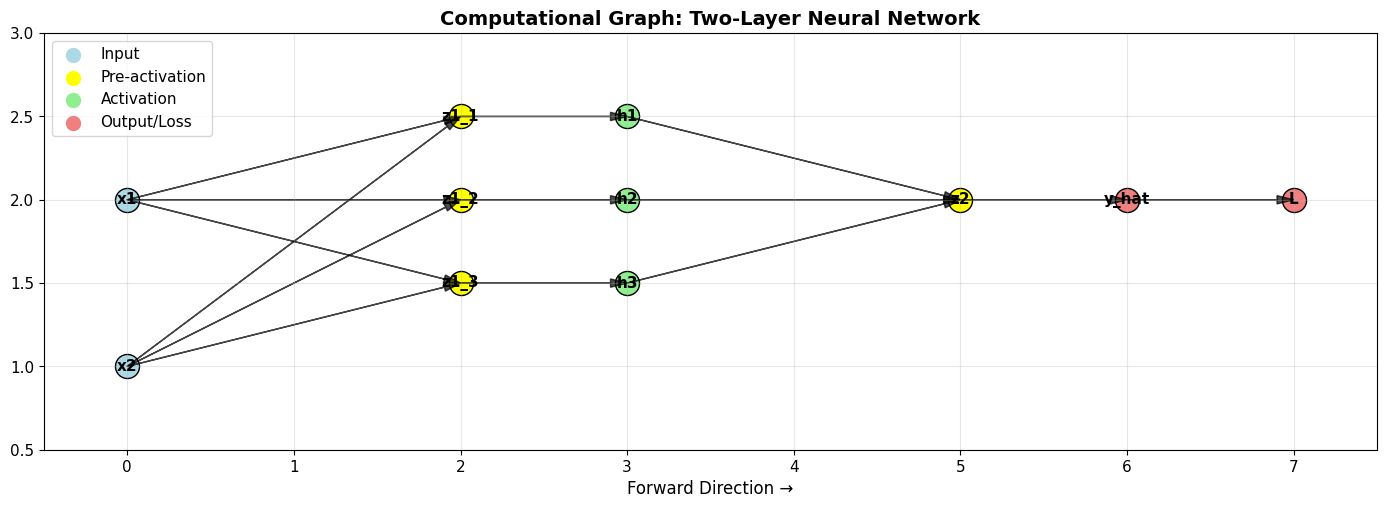

In [4]:
# Numerical Example: Two-Layer Network Backpropagation
print("Numerical Example: Two-Layer Network")
print("=" * 45)

# Network architecture: 2 -> 3 -> 1
np.random.seed(42)

# Input and target
x = np.array([[2.0], [3.0]])  # 2x1 column vector
y = np.array([[1.0]])  # 1x1 target

# Weights and biases
W1 = np.random.randn(3, 2) * 0.5  # 3x2 (hidden_size x input_size)
b1 = np.random.randn(3, 1) * 0.5  # 3x1
W2 = np.random.randn(1, 3) * 0.5  # 1x3 (output_size x hidden_size)
b2 = np.random.randn(1, 1) * 0.5  # 1x1

print("Network Architecture: 2 -> 3 -> 1")
print(f"Input shape: {x.shape}")
print(f"W1 shape: {W1.shape}, b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape}, b2 shape: {b2.shape}")
print(f"Target shape: {y.shape}")

print(f"\nInput: x = {x.flatten()}")
print(f"Target: y = {y.flatten()}")

# Forward pass
print(f"\nForward Pass:")
z1 = np.dot(W1, x) + b1  # 3x1
h = sigmoid(z1)  # 3x1
z2 = np.dot(W2, h) + b2  # 1x1
y_hat = sigmoid(z2)  # 1x1
loss = 0.5 * (y - y_hat)**2

print(f"z1 = W1 @ x + b1 = {z1.flatten()}")
print(f"h = σ(z1) = {h.flatten()}")
print(f"z2 = W2 @ h + b2 = {z2.flatten()}")
print(f"ŷ = σ(z2) = {y_hat.flatten()}")
print(f"Loss = ½(y - ŷ)² = {loss.flatten()}")

# Backward pass
print(f"\nBackward Pass:")

# Output layer gradients
delta2 = -(y - y_hat) * sigmoid_derivative(z2)  # 1x1
dL_dW2 = np.dot(delta2, h.T)  # 1x3
dL_db2 = delta2  # 1x1

print(f"δ2 = -(y - ŷ) ⊙ σ'(z2) = {delta2.flatten()}")
print(f"∂L/∂W2 = δ2 @ h^T = {dL_dW2.flatten()}")
print(f"∂L/∂b2 = δ2 = {dL_db2.flatten()}")

# Hidden layer gradients
dL_dh = np.dot(W2.T, delta2)  # 3x1
delta1 = dL_dh * sigmoid_derivative(z1)  # 3x1 (element-wise)
dL_dW1 = np.dot(delta1, x.T)  # 3x2
dL_db1 = delta1  # 3x1

print(f"∂L/∂h = W2^T @ δ2 = {dL_dh.flatten()}")
print(f"δ1 = ∂L/∂h ⊙ σ'(z1) = {delta1.flatten()}")
print(f"∂L/∂W1 shape: {dL_dW1.shape}")
print(f"∂L/∂b1 = δ1 = {dL_db1.flatten()}")

print(f"\nGradient Summary:")
print(f"Output layer: W2 grad norm = {np.linalg.norm(dL_dW2):.4f}")
print(f"Hidden layer: W1 grad norm = {np.linalg.norm(dL_dW1):.4f}")
print(f"Gradient ratio (hidden/output): {np.linalg.norm(dL_dW1)/np.linalg.norm(dL_dW2):.4f}")

# Visualize the computational graph
def plot_computational_graph():
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # Node positions
    nodes = {
        'x1': (0, 2), 'x2': (0, 1),
        'z1_1': (2, 2.5), 'z1_2': (2, 2), 'z1_3': (2, 1.5),
        'h1': (3, 2.5), 'h2': (3, 2), 'h3': (3, 1.5),
        'z2': (5, 2), 'y_hat': (6, 2), 'L': (7, 2)
    }
    
    # Draw nodes
    for node, (x, y) in nodes.items():
        if node.startswith('x'):
            ax.scatter(x, y, s=300, c='lightblue', edgecolors='black')
        elif node.startswith('z'):
            ax.scatter(x, y, s=300, c='yellow', edgecolors='black')
        elif node.startswith('h'):
            ax.scatter(x, y, s=300, c='lightgreen', edgecolors='black')
        elif node in ['y_hat', 'L']:
            ax.scatter(x, y, s=300, c='lightcoral', edgecolors='black')
        
        ax.annotate(node, (x, y), ha='center', va='center', fontweight='bold')
    
    # Draw connections (simplified)
    connections = [
        ('x1', 'z1_1'), ('x1', 'z1_2'), ('x1', 'z1_3'),
        ('x2', 'z1_1'), ('x2', 'z1_2'), ('x2', 'z1_3'),
        ('z1_1', 'h1'), ('z1_2', 'h2'), ('z1_3', 'h3'),
        ('h1', 'z2'), ('h2', 'z2'), ('h3', 'z2'),
        ('z2', 'y_hat'), ('y_hat', 'L')
    ]
    
    for start, end in connections:
        x1, y1 = nodes[start]
        x2, y2 = nodes[end]
        ax.arrow(x1, y1, x2-x1, y2-y1, head_width=0.05, head_length=0.1, 
                fc='black', ec='black', alpha=0.7, length_includes_head=True)
    
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(0.5, 3)
    ax.set_title('Computational Graph: Two-Layer Neural Network', fontsize=14, fontweight='bold')
    ax.set_xlabel('Forward Direction →', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Add legend
    legend_elements = [
        plt.scatter([], [], c='lightblue', s=100, label='Input'),
        plt.scatter([], [], c='yellow', s=100, label='Pre-activation'),
        plt.scatter([], [], c='lightgreen', s=100, label='Activation'),
        plt.scatter([], [], c='lightcoral', s=100, label='Output/Loss')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_computational_graph()
